In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from skopt import BayesSearchCV
import shap
import pickle

In [4]:
products = pd.read_csv('Products Table.csv')
orders = pd.read_csv('Orders Table.csv')

## Demand Indicators

### Monthly Sales Volume for Each Product

In [5]:
orders['Order Date'] = pd.to_datetime(orders['Order Date']) 

# number of sales for each product per month
monthly_sales_volume = orders.groupby(['ProductID', pd.Grouper(key='Order Date', freq='M')])['OrderID'].count().reset_index()
monthly_sales_volume.rename(columns={'OrderID': 'Monthly Sales Volume'}, inplace=True)

/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_95735/2658778723.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales_volume = orders.groupby(['ProductID', pd.Grouper(key='Order Date', freq='M')])['OrderID'].count().reset_index()


### Sales Trends

In [6]:
# 3-month rolling average of sales volume for each product
monthly_sales_volume['Sales Trend'] = monthly_sales_volume.groupby('ProductID')['Monthly Sales Volume'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
products = products.merge(monthly_sales_volume, on = 'ProductID', how = 'inner')

### Promotional Influence

In [7]:
# number of sales for each product when on promotion
promo_sales_volume = orders[orders['Promotional Period'] == 1].groupby('ProductID')['OrderID'].count().reset_index()
promo_sales_volume.rename(columns={'OrderID': 'Promo Sales Volume'}, inplace=True)

# number of sales for each product when not on promotion
non_promo_sales_volume = orders[orders['Promotional Period'] == 0].groupby('ProductID')['OrderID'].count().reset_index()
non_promo_sales_volume.rename(columns={'OrderID': 'Non Promo Sales Volume'}, inplace=True)

# merging
promo_influence = promo_sales_volume.merge(non_promo_sales_volume, on = 'ProductID', how = 'outer')
promo_influence = promo_influence.fillna(0) 

products = products.merge(promo_influence, on = 'ProductID', how = 'inner')

## Competitor Pricing

In [8]:
products['Competitor Price'] = round(products['Price'] * np.random.uniform(0.7, 1.3, size = len(products)), 2)
products['Price Comparison Index'] = products['Price']/products['Competitor Price'] # ratio of own price to competitor's price

## Inventory Levels

### Stock Levels

In [9]:
products['Stock Level'] = np.random.randint(0, 100, size = len(products))

### Restock Frequency

In [10]:
products['Restock Frequency'] = np.random.choice([10, 20, 30], len(products))

## Dynamic Pricing Model

### Preparing our features

In [11]:
df = products[['Category', 'Monthly Sales Volume', 'Sales Trend', 'Promo Sales Volume', 'Non Promo Sales Volume', 'Price Comparison Index', 'Stock Level', 'Restock Frequency', 'Price']]
df.drop_duplicates(inplace=True)

# removing extreme values for prices
# we choose the threshold to be the any prices below 95th percentile and above 5th percentile
df = df[(df['Price'] >= df['Price'].quantile(0.05)) & (df['Price'] <= df['Price'].quantile(0.95))]

/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_95735/502136623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


### Train Test Split

In [12]:
X = df.drop('Price', axis = 1)
X = pd.get_dummies(X, columns=['Category'], drop_first=True)
y = df[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# converting boolean to binary for SHAP later on
X_train['Category_Electronics'] = X_train['Category_Electronics'].astype(int)
X_train['Category_Home Appliances'] = X_train['Category_Home Appliances'].astype(int)
X_test['Category_Electronics'] = X_test['Category_Electronics'].astype(int)
X_test['Category_Home Appliances'] = X_test['Category_Home Appliances'].astype(int)

### Hyperparameter Tuning

In [13]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# hyperparameter space for Bayesian search
param_space = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'max_depth': (3, 10),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'alpha': (0.01, 10, 'log-uniform'),  # L1 regularization term
    'lambda': (0.01, 10, 'log-uniform')  # L2 regularization term
}

bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    cv=4,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

bayes_search.fit(X_train, y_train)


model = bayes_search.best_estimator_
print(f'RMSE (on validation set): {-bayes_search.best_score_}')

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE (on test set): {rmse}')

RMSE (on validation set): 11.23099053057209
RMSE (on test set): 11.089193468089004


### Feature Importance

Text(0.5, 1.0, 'Feature Importance from XGBoost')

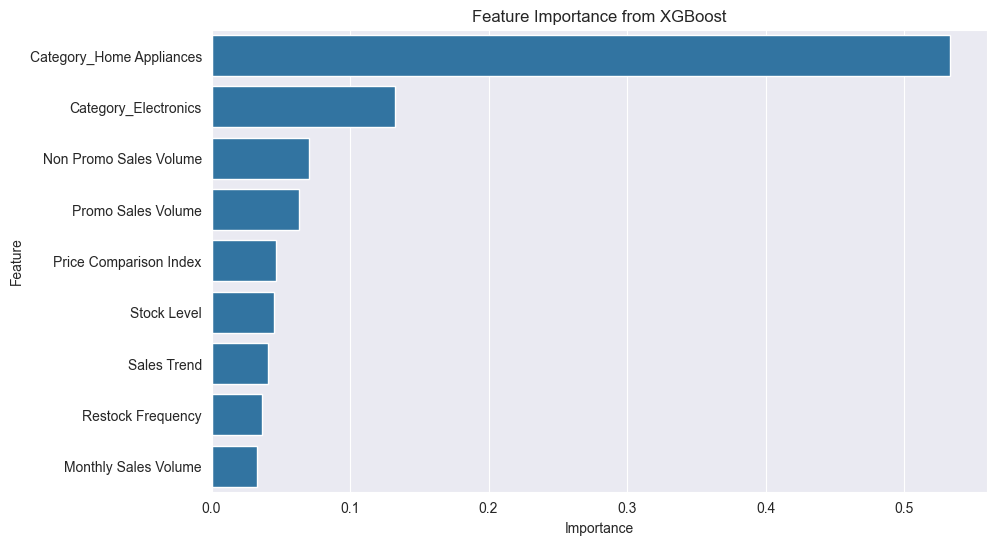

In [14]:
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance from XGBoost")

### SHAP

100%|===================| 27107/27170 [03:45<00:00]        

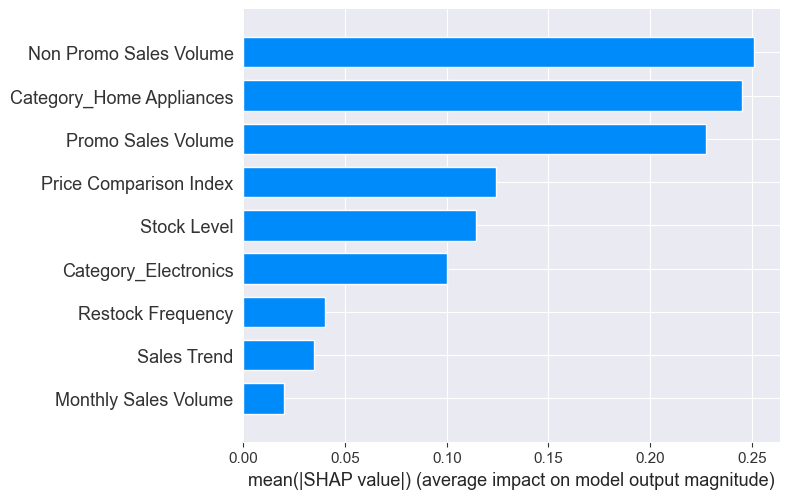

In [15]:
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

sns.set_style('darkgrid')
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Saving Trained Model

In [16]:
with open('PricingModel.pkl', 'wb') as file:
    pickle.dump(model, file)